# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="darkgrid")


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import tensorflow as tf

So now we can read in the data and work on a random forest classifier, since we are working with a categorical target. 

In [2]:
df = pd.read_csv('data/esrb_ratings_scraped.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     12000 non-null  object
 1   console                   12000 non-null  object
 2   alcohol_reference         12000 non-null  int64 
 3   animated_blood            12000 non-null  int64 
 4   blood                     12000 non-null  int64 
 5   blood_and_gore            12000 non-null  int64 
 6   cartoon_violence          12000 non-null  int64 
 7   crude_humor               12000 non-null  int64 
 8   drug_reference            12000 non-null  int64 
 9   fantasy_violence          12000 non-null  int64 
 10  intense_violence          12000 non-null  int64 
 11  language                  12000 non-null  int64 
 12  mild_blood                12000 non-null  int64 
 13  mild_cartoon_violence     12000 non-null  int64 
 14  mild_fantasy_violence 

Drop duplicates

In [3]:
df = df.drop_duplicates(keep='first')

Select our features and target

In [4]:
features = df.drop(['title', 'console', 'esrb_rating'], axis=1)
target = df['esrb_rating']

split data into training and test data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=39)


In our first few iterations we received about 88% accuracy. I then scraped data from ESRB.org to increase the size of the dataset to 6x the size. I reran this notebook with that data and our accuracy dropped to 85%. Let's incorporate SMOTE to see if that can improve.

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=39)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Now let's initialize our random forest and fit the data. 

In [7]:
rfc_model = RandomForestClassifier(n_estimators=100, random_state=39)

rfc_model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=39)

and then let's see how our model works out of the box.

In [8]:
y_pred = rfc_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8469991546914624
Classification Report:
               precision    recall  f1-score   support

           E       0.95      0.89      0.92       973
          ET       0.67      0.81      0.73       480
           M       0.89      0.90      0.90       285
           T       0.84      0.79      0.82       628

    accuracy                           0.85      2366
   macro avg       0.84      0.85      0.84      2366
weighted avg       0.86      0.85      0.85      2366



Some of the classes performed better than the others in terms of recall and precision. Let's take a look at this.

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

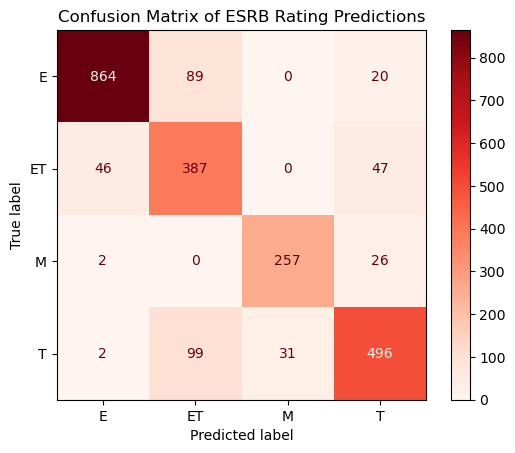

In [10]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rfc_model.classes_)

# Plot the confusion matrix
graph = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_model.classes_)
graph.plot(cmap=plt.cm.Reds)

# Set title and show plot
plt.title("Confusion Matrix of ESRB Rating Predictions")
plt.show()

Let's try and improve on this model. We can start with checking out feature importance, since we have around 30 features.

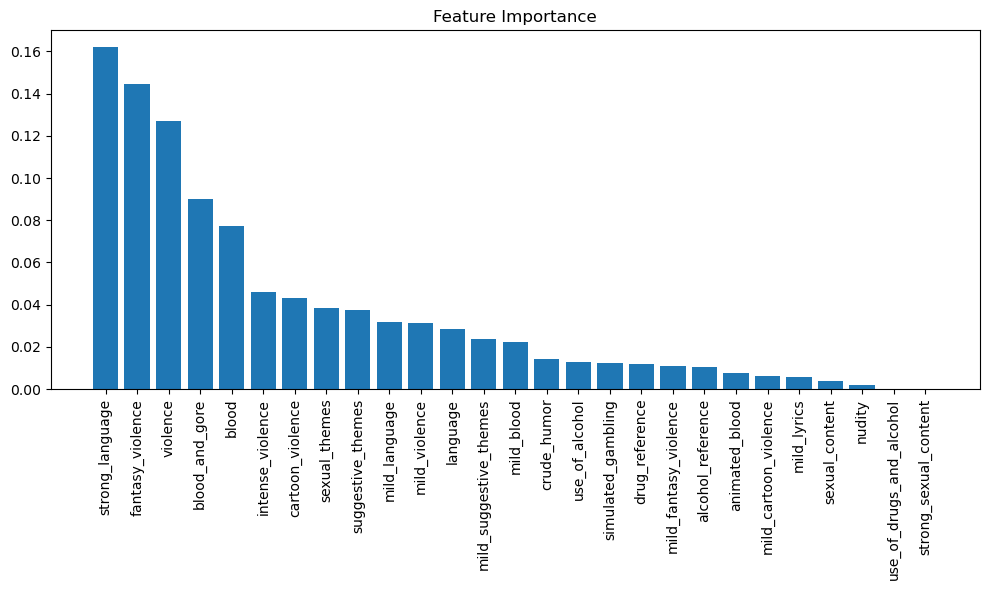

In [11]:
importances = rfc_model.feature_importances_
feature_names = features.columns
sorted_indices = importances.argsort()[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Let's try dropping all features that fall belove 0.01

* After trying this step, this results were not warranted. Keeping all features. Moving forward

In [12]:
# # Create a mask for features with importance greater than or equal to 0.01
# mask = importances >= 0.01

# # Filter the features based on the mask
# important_features = feature_names[mask]

# # Drop the features with importance below 0.01 from the dataset
# X_train_reduced = X_train[important_features]
# X_test_reduced = X_test[important_features]

In [13]:
# model.fit(X_train_reduced, y_train)

# y_pred = model.predict(X_test_reduced)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

Our accuracy dropped from that. Let's forgo that and work on another path. We can try a GridSearch

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rfc_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [15]:
y_grid_pred = grid_search.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_grid_pred))
print("Classification Report:\n", classification_report(y_test, y_grid_pred))

Accuracy: 0.8448858833474218
Classification Report:
               precision    recall  f1-score   support

           E       0.95      0.89      0.92       973
          ET       0.66      0.81      0.73       480
           M       0.88      0.90      0.89       285
           T       0.85      0.78      0.81       628

    accuracy                           0.84      2366
   macro avg       0.84      0.85      0.84      2366
weighted avg       0.86      0.84      0.85      2366



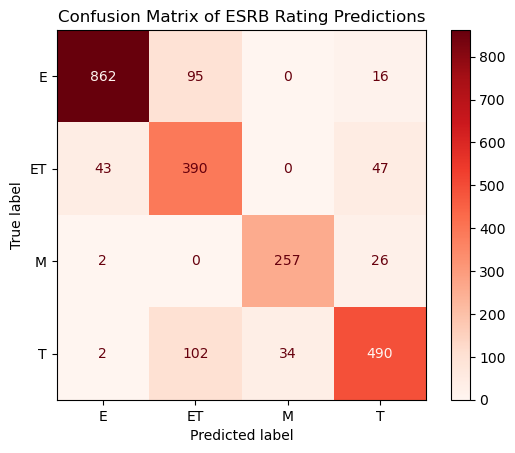

In [16]:
# Generate the confusion matrix
gridCM = confusion_matrix(y_test, y_grid_pred, labels=grid_search.classes_)

# Plot the confusion matrix
graph = ConfusionMatrixDisplay(confusion_matrix=gridCM, display_labels=grid_search.classes_)
graph.plot(cmap=plt.cm.Reds)

# Set title and show plot
plt.title("Confusion Matrix of ESRB Rating Predictions")
plt.show()

We got the exact same numbers. Maybe XGBClassifier will yield improvements?

In [17]:
# Run this cell if you need this library
# !pip install xgboost

We need to encode our target since XGBclassifier is looking for numeric data.
* We originally applied smote, but I am going to try PCA instead this time around. 

In [18]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode the ESRB ratings as numeric values
le = LabelEncoder()
y_encoded = le.fit_transform(target)  # Convert 'E', 'T', etc. to numbers

# Split the data into training and testing sets (80% train, 20% test)
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(features, y_encoded, test_size=0.2, random_state=39)

smote=SMOTE(random_state=39)
X_train_boost_res, y_train_boost_res = smote.fit_resample(X_train_boost, y_train_boost)

xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_clf.fit(X_train_boost_res, y_train_boost_res)
y_pred_xgb = xgb_clf.predict(X_test_boost)

In [19]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test_boost, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test_boost, y_pred_xgb))

Accuracy: 0.8431952662721893
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       973
           1       0.67      0.80      0.73       480
           2       0.88      0.89      0.88       285
           3       0.84      0.77      0.80       628

    accuracy                           0.84      2366
   macro avg       0.83      0.84      0.83      2366
weighted avg       0.85      0.84      0.85      2366



Accuracy dropped about 3% with PCA

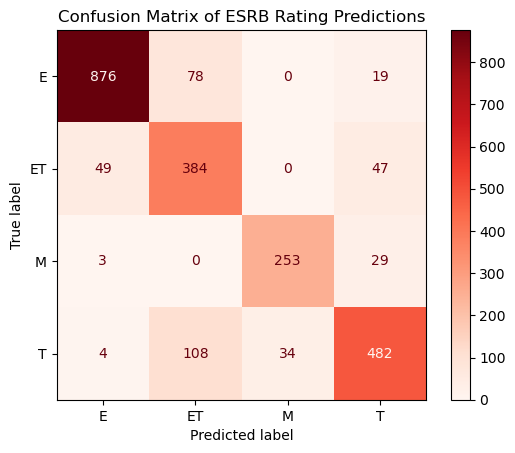

In [20]:
# Generate the confusion matrix
xgbCM = confusion_matrix(y_test_boost, y_pred_xgb)

# Plot the confusion matrix
graph = ConfusionMatrixDisplay(confusion_matrix=xgbCM, display_labels=grid_search.classes_)
graph.plot(cmap=plt.cm.Reds)

# Set title and show plot
plt.title("Confusion Matrix of ESRB Rating Predictions")
plt.show()

Available metrics: odict_keys(['mlogloss'])


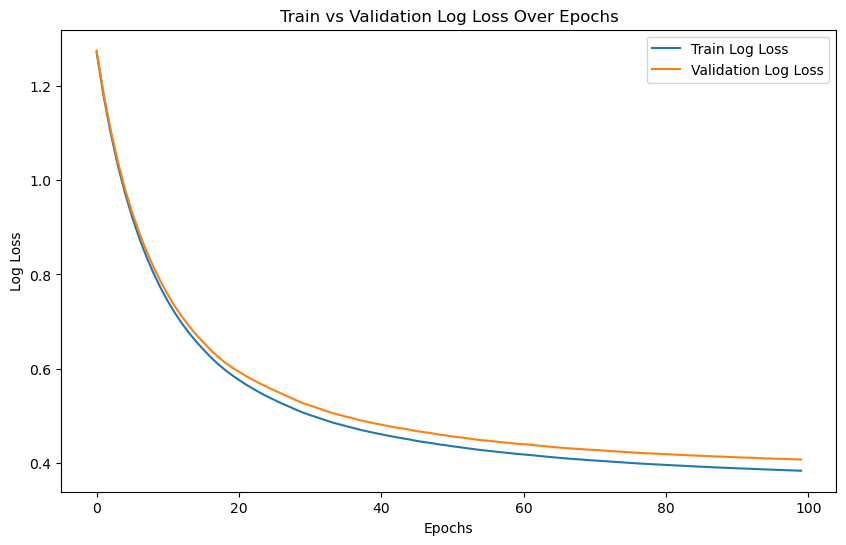

In [21]:
# Define the evaluation set (training and validation data)
eval_set = [(X_train_boost_res, y_train_boost_res), (X_test_boost, y_test_boost)]

# Train the model and track performance
xgb_clf.fit(X_train_boost_res, y_train_boost_res, eval_set=eval_set, verbose=False)

# Retrieve performance metrics
results = xgb_clf.evals_result()

print('Available metrics:', results['validation_0'].keys())

# Extract logloss for training and validation (assuming mlogloss is available for multi-class)
train_metric = results['validation_0']['mlogloss']  # or use 'logloss' for binary classification
test_metric = results['validation_1']['mlogloss']


# Plot the training and validation metric over epochs
epochs = len(train_metric)
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))

plt.plot(x_axis, train_metric, label='Train Log Loss')
plt.plot(x_axis, test_metric, label='Validation Log Loss')

# Set the plot details
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Train vs Validation Log Loss Over Epochs')
plt.legend()
plt.show()

Doesn't seem to be much in the way of over or underfitting. We aren't getting too much difference. It seems be to dropping as we try more. So let's move onto something more advanced.

* Adding PCA definitely made this graph worse. We won't go forward with this.

_________

## Advanced Machine Learning


______

Let's now try to work on a neural network.

* First iteration: 3 Dense layers.
* Second iteration: changed learning rate to 0.0001
* Third iteration: Added another Dense layer and a dropout layer.
* Fourth iteration: We now have 12k rows of data. We added smote. Accuracy is lower at 85% and stays there very early on in the process. 
* Fifth iteration: Lowering epoch size since learning is stopping. Adding another Dense layer.
* Sixth iteration: Adding a regularizer to help prevent overfitting

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

# # Encode the ESRB ratings as numeric values
# le = LabelEncoder()
# y_encoded = le.fit_transform(target)  # Convert 'E', 'T', etc. to numbers

# Split the data into training and testing sets (80% train, 20% test)
# X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(features, y_encoded, test_size=0.2, random_state=39)

# smote=SMOTE(random_state=39)
# X_train_boost_res, y_train_boost_res = smote.fit_resample(X_train_boost, y_train_boost)

# # Encode the target variable as integers
# y_train_encoded = le.fit_transform(y_train_boost)
# y_test_encoded = le.transform(y_test_boost)


# One-hot encode the target variable for use in categorical cross-entropy
y_train_one_hot_res = to_categorical(y_train_boost_res, num_classes=len(le.classes_))
y_test_one_hot = to_categorical(y_test_boost, num_classes=len(le.classes_))


nn_model = Sequential()
nn_model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.08)))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.7)) # dropout some data to help with overfitting
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(len(le.classes_), activation='softmax'))  # Output layer for classification

# Set a custom learning rate for the Adam optimizer
learning_rate = 0.0005  # You can adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)

nn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


nn_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               7168      
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                      


X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(features, y_encoded, test_size=0.2, random_state=39)

smote=SMOTE(random_state=39)
X_train_boost_res, y_train_boost_res = smote.fit_resample(X_train_boost, y_train_boost)

In [48]:
#train model
history = nn_model.fit(X_train_boost_res, y_train_one_hot_res, epochs=75, batch_size=16, validation_data=(X_test_boost, y_test_one_hot))

Epoch 1/75
922/922 [==============================] - 9s 9ms/step - loss: 1.5090 - accuracy: 0.7528 - val_loss: 0.5681 - val_accuracy: 0.8301
Epoch 2/75
922/922 [==============================] - 8s 9ms/step - loss: 0.6005 - accuracy: 0.8054 - val_loss: 0.4756 - val_accuracy: 0.8204
Epoch 3/75
922/922 [==============================] - 8s 9ms/step - loss: 0.5459 - accuracy: 0.8129 - val_loss: 0.4580 - val_accuracy: 0.8242
Epoch 4/75
922/922 [==============================] - 8s 9ms/step - loss: 0.5181 - accuracy: 0.8130 - val_loss: 0.4466 - val_accuracy: 0.8267
Epoch 5/75
922/922 [==============================] - 8s 9ms/step - loss: 0.5054 - accuracy: 0.8198 - val_loss: 0.4451 - val_accuracy: 0.8428
Epoch 6/75
922/922 [==============================] - 8s 9ms/step - loss: 0.4983 - accuracy: 0.8206 - val_loss: 0.4380 - val_accuracy: 0.8390
Epoch 7/75
922/922 [==============================] - 8s 9ms/step - loss: 0.4917 - accuracy: 0.8266 - val_loss: 0.4590 - val_accuracy: 0.8288
Epoch 

Let's plot to check for overfitting

In [49]:
def plot_ml_acc_loss (history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Show the plots
    plt.tight_layout()
    plt.show()

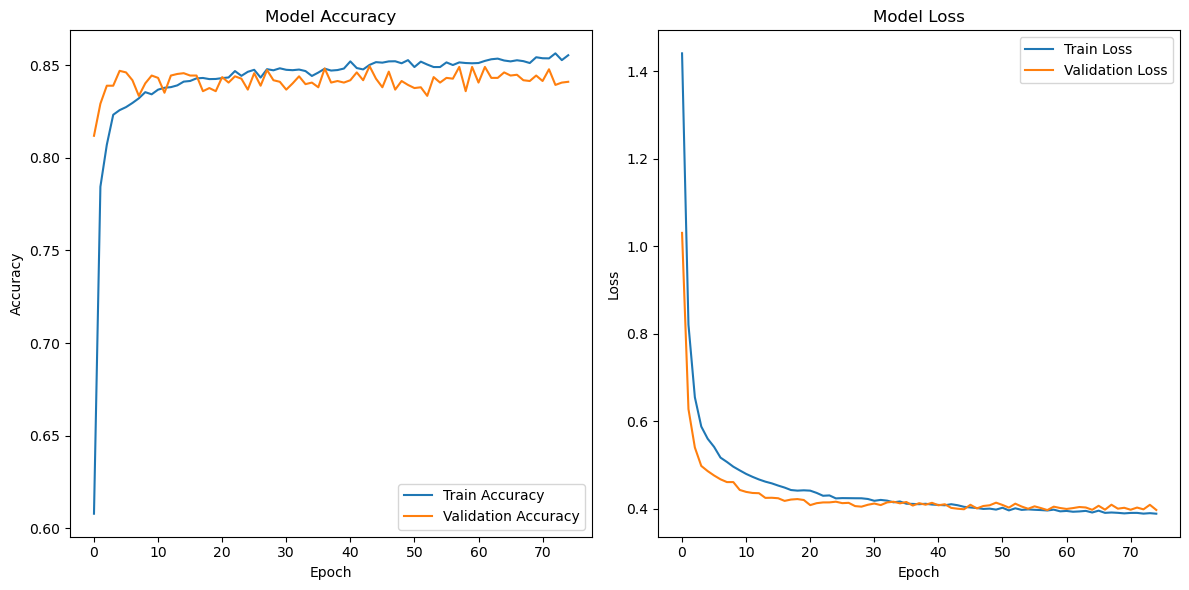

In [29]:
plot_ml_acc_loss(history)

First iteration - It looks like our model accuracy peaks at around 35 epochs and our model loss plateaus at 20 epochs. Let's work on improving that. (Original run through at 0.001 LR)

Changes to 0.0001 learning rate and the graph above looks much more fluid. 

Let's use EarlyStopping and Reduce Learning Rate to try and help with overfitting

In [50]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Add EarlyStopping to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# ReduceLROnPlateau: Reduce the learning rate if validation loss plateaus for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)

# Re-train the model with early stopping
history = nn_model.fit(X_train_res, y_train_one_hot_res, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test_one_hot), 
                    callbacks=[early_stopping, reduce_lr])

# After EarlyStopping, the best model will be restored.
# Evaluate the model on the test set
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/100
461/461 [==============================] - 3s 6ms/step - loss: 0.4102 - accuracy: 0.8463 - val_loss: 5.6364 - val_accuracy: 0.2633 - lr: 5.0000e-04
Epoch 2/100
461/461 [==============================] - 4s 9ms/step - loss: 0.4041 - accuracy: 0.8441 - val_loss: 5.4211 - val_accuracy: 0.2633 - lr: 5.0000e-04
Epoch 3/100
461/461 [==============================] - 4s 9ms/step - loss: 0.4045 - accuracy: 0.8469 - val_loss: 5.6560 - val_accuracy: 0.2633 - lr: 5.0000e-04
Epoch 4/100
461/461 [==============================] - 4s 9ms/step - loss: 0.4017 - accuracy: 0.8491 - val_loss: 5.7083 - val_accuracy: 0.2637 - lr: 5.0000e-04
Epoch 5/100
461/461 [==============================] - 4s 10ms/step - loss: 0.4047 - accuracy: 0.8448 - val_loss: 5.7797 - val_accuracy: 0.2654 - lr: 5.0000e-04
Epoch 6/100
461/461 [==============================] - 3s 6ms/step - loss: 0.3985 - accuracy: 0.8483 - val_loss: 5.7488 - val_accuracy: 0.2654 - lr: 2.5000e-04
Epoch 7/100
461/461 [==================

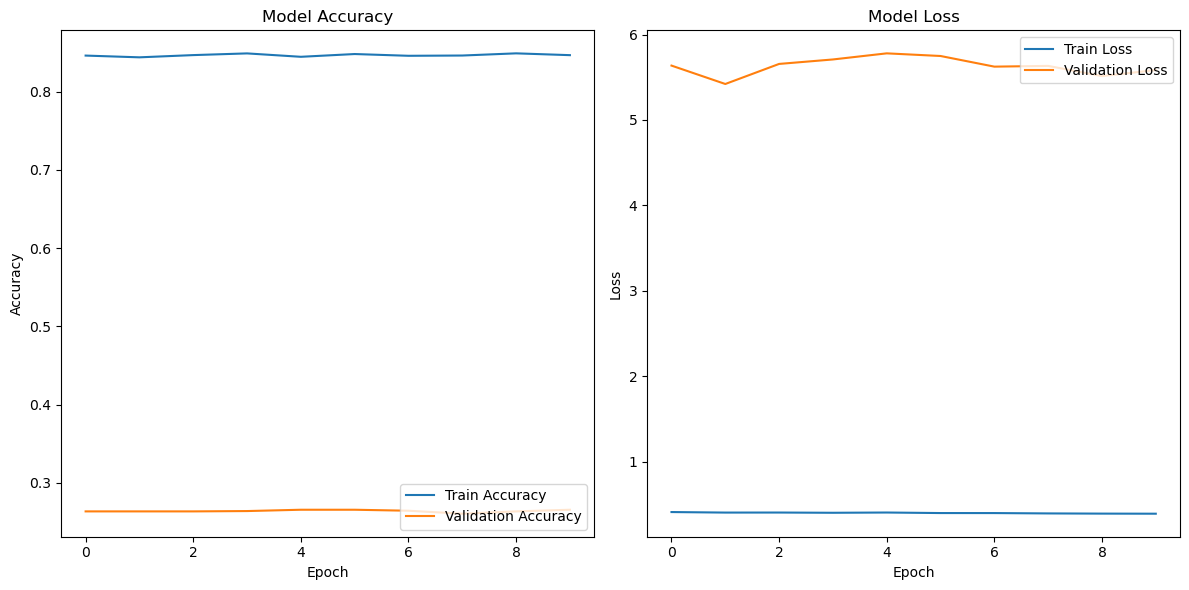

In [51]:
plot_ml_acc_loss(history)

74/74 [==============================] - 0s 4ms/step


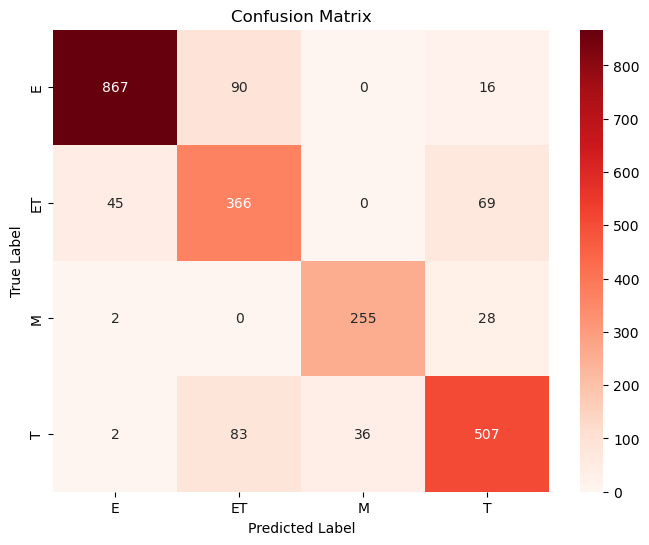

In [52]:
# Predict the classes for the test set
y_pred = nn_model.predict(X_test_boost)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

# Convert one-hot encoded labels back to integers for comparison
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

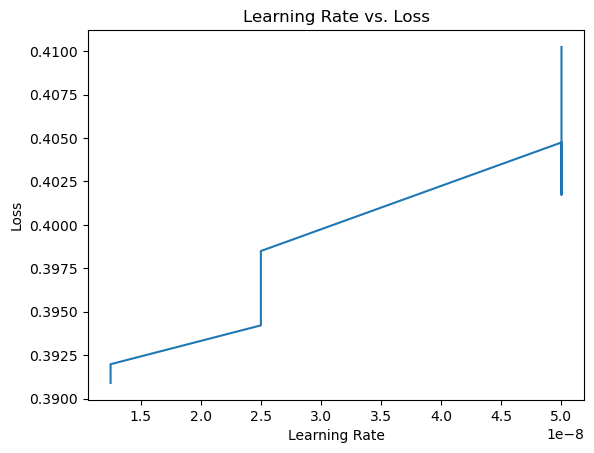

In [53]:
# Plot learning rate reduction if you used ReduceLROnPlateau
lrs = 0.0001 * np.array(history.history['lr'])
plt.plot(lrs, history.history['loss'])
plt.title('Learning Rate vs. Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

____

## Let's use a smaller dataset for testing

____

Run on new test data.

In [54]:
test_data = pd.read_csv('data/esrb_ratings_test_set.csv')
test_target = 'esrb_rating'

We encode the target column in this new set to match our model

In [55]:
# Encode the ESRB ratings as numeric values
test_le = LabelEncoder()
test_data[test_target] = test_le.fit_transform(test_data[test_target])  # Convert 'E', 'T', etc. to numbers

In [56]:
# 
test_data = test_data.drop(['title', 'console', 'esrb_rating'], axis=1)


In [57]:
# Get predictions from the model
predictions = nn_model.predict(test_data)

# If it's a classification problem and you want the class with the highest probability
predicted_classes = predictions.argmax(axis=1)

1/1 [==============================] - 0s 17ms/step


In [58]:
predicted_classes

array([1, 0, 3, 2, 1], dtype=int64)

In [59]:
predicted_labels = test_le.inverse_transform(predicted_classes)
print(predicted_labels)

['ET' 'E' 'T' 'M' 'ET']


We were accurate 4 out of 5 times for a single run of this data. The first ET should be T. Given that the models above were definitely showing some interesting results for T (false positives), it sort of makes sense. 

### Recommendations

Based off the findings in the original dataset and the enlarged dataset, it seems like the definitions for E10+ and Teen are too ambiguous and close. Some games that are E10+ have too many descriptors that draw them closer to Teen. I would suggest just removing the E10+ since it's only 3 years difference from Teen. 